In [21]:
### This notebook aims to get different variables for the same track and compare
import GeneralFunctions as Gfn
import h5py                          # general HDF5 reading/writing library
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd

In [2]:
## Settings for required files

date_range = ['2019-09-01','2019-09-02']
spatial_extent = [-55,-78, -25, -60] ## lon1, lat1, lon2, lat2
sector_name = 'Weddell'

path = '/tmp/floes_HR/'+sector_name+'/'

In [6]:
## Step 1: load some files!
filelist_07 = Gfn.get_files(path,"ATL07")
filelist_10 = Gfn.get_files(path,"ATL10")

file1_07 = filelist_07[0]
file1_10 = filelist_10[0]

## Check the time details are the same
print(file1_07)
print(file1_10)

/tmp/floes_HR/Weddell/
You have 3 files matching the filename pattern to be read in.
/tmp/floes_HR/Weddell/
You have 27 files matching the filename pattern to be read in.
/tmp/floes_HR/Weddell/processed_ATL07-02_20190901021447_09930401_005_01.h5
/tmp/floes_HR/Weddell/processed_ATL10-02_20190901021447_09930401_005_02.h5


In [92]:
## Get some information from the files - interactive cell for investigation
ATL07=h5py.File(file1_07, 'r')
ATL10=h5py.File(file1_10, 'r')

ATL07[beam+'/sea_ice_segments/'].keys()
#['delta_time', 'geolocation', 'geophysical', 'geoseg_beg', 'geoseg_end', 
#'height_segment_id', 'heights', 'latitude', 'longitude', 'seg_dist_x', 'stats']

#list(ATL10[beam].keys())
#['freeboard_beam_segment', 'leads']
ATL10[beam+'/freeboard_beam_segment/'].keys()
#<KeysViewHDF5 ['beam_fb_height', 'beam_fb_hist', 'beam_fb_length', 'beam_fb_sigma', 
#'beam_freeboard', 'beam_lead_n', 'beam_lead_ndx', 'beam_refsurf_alongtrack_slope', 
#'beam_refsurf_dist_x', 'beam_refsurf_earth_free2mean', 'beam_refsurf_geoid', 
#'beam_refsurf_geoid_free2mean', 'beam_refsurf_height', 'beam_refsurf_interp_flag', 
#'beam_refsurf_mss', 'beam_refsurf_sigma', 'delta_time', 'ds_si_hist_bins', 
#'fbswath_ndx', 'geophysical', 'height_segments', 'latitude', 'longitude'
ATL10[beam+'/freeboard_beam_segment/height_segments/'].keys()
#KeysViewHDF5 ['asr_25', 'backgr_calc', 'backgr_r_200', 'backgr_r_25', 'background_r_norm', 
#              'bsnow_con', 'bsnow_h', 'cloud_flag_asr', 'cloud_flag_atm', 'delta_time', 
#              'height_segment_confidence', 'height_segment_height', 'height_segment_length_seg', 
#              'height_segment_rms', 'height_segment_ssh_flag', 'height_segment_surf_sigma', 
#              'height_segment_type', 'height_segment_w_gaussian', 'ice_conc', 'latitude', 
#              'layer_flag', 'longitude', 'msw_flag', 'photon_rate', 'podppd_flag']

ATL10[beam+'/leads/'].keys()
#KeysViewHDF5 ['delta_time', 'latitude', 'lead_dist_x', 'lead_height', 'lead_length', 
#'lead_sigma', 'longitude', 'ssh_n', 'ssh_ndx']


(295,)
(295,)
(295,)
(295,)


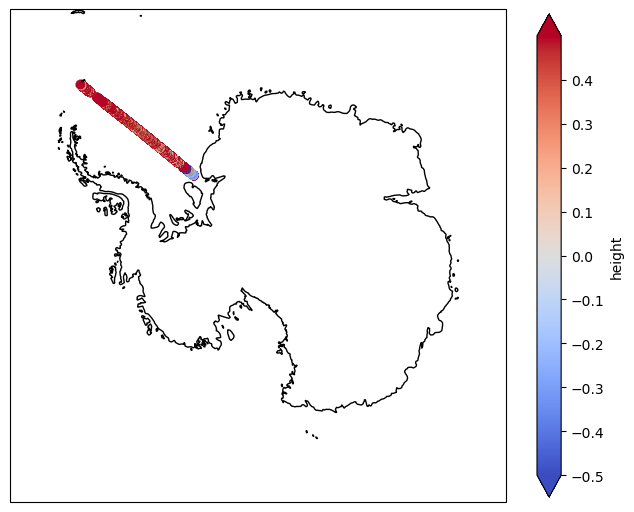

In [24]:
### Where is the track?
## Copied from Xueke!

filepath = file1_07
ATL07=h5py.File(filepath, 'r')

beam = 'gt1l'
lons = xr.DataArray(ATL07[beam+'/sea_ice_segments/longitude'][:],dims=['segs'])
lons.name='lons'
lats = xr.DataArray(ATL07[beam+'/sea_ice_segments/latitude'][:],dims=['segs'])
lats.name='lats'
lons360 = lons.where(lons.values>0, other=lons.values+360) #add 360 to lons less than 0

delta_time=ATL07[beam+'/sea_ice_segments/delta_time'][:] 
time = np.datetime64('2018-01-01') + (delta_time-86400*0.015).astype('timedelta64[s]' ) 


#Read data
seg_dist = xr.DataArray(ATL07[beam+'/sea_ice_segments/seg_dist_x'][:],dims=['segs'])
seg_dist.name = 'seg_dist' 

height = xr.DataArray(ATL07[beam+'/sea_ice_segments/heights/height_segment_height'][:],dims=['segs'])
height.name = 'height'

#Create a new xarray that has all necessary info 
ds=xr.merge([seg_dist, height])
ds.coords['lon'] = lons
ds.coords['lat'] = lats
ds.coords['time'] = xr.DataArray(time,dims=['segs'])
ds.coords['delta_time'] = xr.DataArray(delta_time,dims=['segs'])

ds.coords['lon360'] = lons360
ds.coords['segs'] = xr.DataArray(np.arange(0,len(height),1),dims=['segs'])
ds

#Plot along-track height data
vmin=-0.5
vmax=0.5
ticks=np.arange(vmin,vmax,0.1)

plt.figure(figsize=(8,8), dpi= 100)
ax = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=0)) # choose polar sterographic for projection
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.set_extent([-180,180,-90,-60], ccrs.PlateCarree())  # minlon, minlat, maxlon, maxlat
plt.scatter(ds['lon'][:], ds['lat'][:],c=ds['height'][:], cmap=plt.cm.get_cmap('coolwarm'), vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
plt.colorbar(label='height', shrink=0.8, ticks=ticks,extend='both');

In [97]:
# Load the ICESat-2 data. We will just look at the central beams (GT2R/L)
## Copied from case_analysis by Xueke
beam_r = 'gt2r'
beam_l = 'gt2l'

### First, get ATL07 information
with h5py.File(file1_07, 'r') as f:
    data_r_07 = pd.DataFrame(data={'lat': f[beam_r+'/sea_ice_segments/latitude'][:],
                                  'lon': f[beam_r+'/sea_ice_segments/longitude'][:],
                                  'elev': f[beam_r+'/sea_ice_segments/heights/height_segment_height'][:]})
    data_l_07 = pd.DataFrame(data={'lat': f[beam_l+'/sea_ice_segments/latitude'][:],
                                  'lon': f[beam_l+'/sea_ice_segments/longitude'][:],
                                  'elev': f[beam_l+'/sea_ice_segments/heights/height_segment_height'][:]})
    
ATL10[beam+'/leads/'].keys()
#KeysViewHDF5 ['delta_time', 'latitude', 'lead_dist_x', 'lead_height', 'lead_length', 
#'lead_sigma', 'longitude', 'ssh_n', 'ssh_ndx']
print(np.shape(ATL10[beam+'/leads/lead_dist_x']))
print(np.shape(ATL10[beam+'/leads/lead_height']))
print(np.shape(ATL10[beam+'/leads/lead_length']))
print(np.shape(ATL10[beam+'/leads/latitude']))   

### Then, get ATL10 information (leads)
with h5py.File(file1_10, 'r') as f:
    data_r_10_lead = pd.DataFrame(data={
                                  'lat': f[beam_r+'/leads/latitude'][:],
                                  'lon': f[beam_r+'/leads/longitude'][:],
                                  'lead_height': f[beam_r+'/leads/lead_height'][:],
                                  'lead_length': f[beam_r+'/leads/lead_length'][:]})
    data_l_10_lead = pd.DataFrame(data={
                                  'lat': f[beam_l+'/leads/latitude'][:],
                                  'lon': f[beam_l+'/leads/longitude'][:],
                                  'lead_height': f[beam_l+'/leads/lead_height'][:],
                                  'lead_length': f[beam_l+'/leads/lead_length'][:]})

    
with h5py.File(file1_10, 'r') as f:
    data_r_10_free = pd.DataFrame(data={'lat': f[beam_r+'/freeboard_beam_segment/height_segments/latitude'][:],
                                  'lon': f[beam_r+'/freeboard_beam_segment/height_segments/longitude'][:],
                                  'free_height': f[beam_r+'/freeboard_beam_segment/height_segments/height_segment_height'][:],
                                  'ice_conc': f[beam_r+'/freeboard_beam_segment/height_segments/ice_conc'][:]})
    data_l_10_free = pd.DataFrame(data={'lat': f[beam_l+'/freeboard_beam_segment/height_segments/latitude'][:],
                                  'lon': f[beam_l+'/freeboard_beam_segment/height_segments/longitude'][:],
                                  'free_height': f[beam_l+'/freeboard_beam_segment/height_segments/height_segment_height'][:],
                                  'ice_conc': f[beam_l+'/freeboard_beam_segment/height_segments/ice_conc'][:]})
 

(295,)
(295,)
(295,)
(295,)


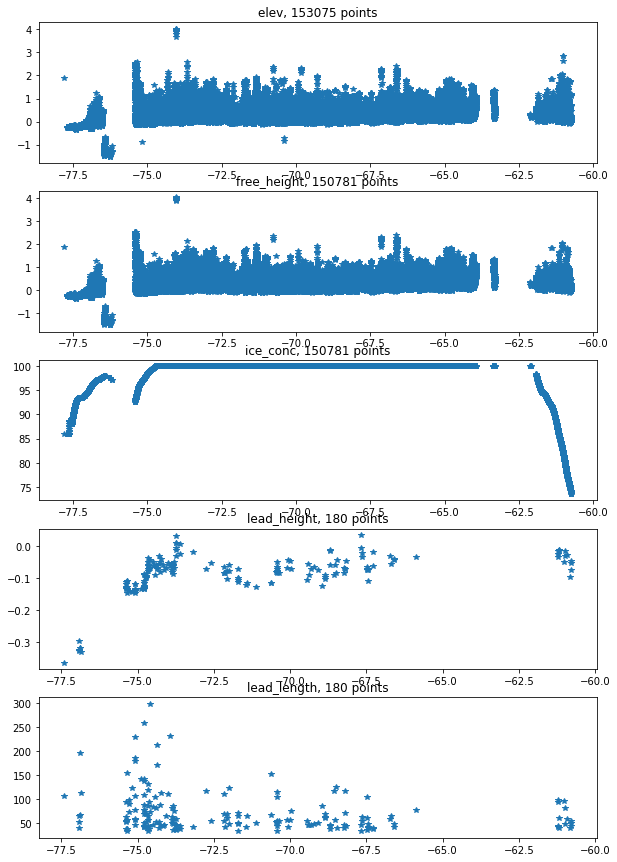

In [99]:
def plot_line_and_label(axn,dpanda,xvar,yvar):
    if xvar is None:
        xplot = np.arange(0,len(dpanda[yvar]))
    else:
        xplot = dpanda[xvar]
    ax[axn].plot(xplot,dpanda[yvar],'*')
    ax[axn].set_title(yvar+', '+str(len(dpanda[yvar]))+' points')
    return

fig,ax = plt.subplots(5,figsize=(10,15))
plot_line_and_label(0,data_r_07,'lat','elev')
plot_line_and_label(1,data_r_10_free,'lat','free_height')
plot_line_and_label(2,data_r_10_free,'lat','ice_conc')
plot_line_and_label(3,data_r_10_lead,'lat','lead_height')
plot_line_and_label(4,data_r_10_lead,'lat','lead_length')


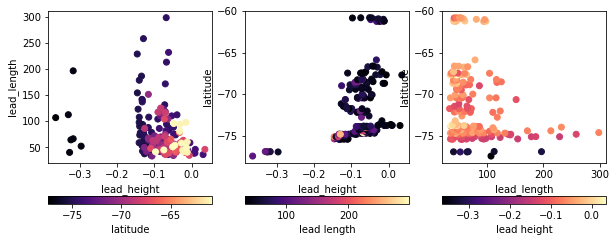

In [119]:
### Quick look: is there a correlation of lead length with height or latitude?
fig,ax = plt.subplots(1,3,figsize=(10,4))
px=ax[0].scatter(data_r_10_lead['lead_height'],data_r_10_lead['lead_length'],c=data_r_10_lead['lat'],cmap='magma')
cb1=plt.colorbar(px,ax=ax[0],orientation='horizontal')
px=ax[1].scatter(data_r_10_lead['lead_height'],data_r_10_lead['lat'],c=data_r_10_lead['lead_length'],cmap='magma')
cb2=plt.colorbar(px,ax=ax[1],orientation='horizontal')
px=ax[2].scatter(data_r_10_lead['lead_length'],data_r_10_lead['lat'],c=data_r_10_lead['lead_height'],cmap='magma')
cb3=plt.colorbar(px,ax=ax[2],orientation='horizontal')

ax[0].set_xlabel('lead_height')
ax[0].set_ylabel('lead_length')
ax[1].set_xlabel('lead_height')
ax[1].set_ylabel('latitude')
ax[2].set_xlabel('lead_length')
ax[2].set_ylabel('latitude')

cb1.set_label('latitude')
cb2.set_label('lead length')
cb3.set_label('lead height')

#####


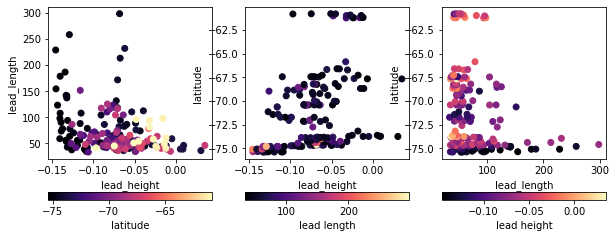

In [120]:
### Quick look: is there a correlation of lead length with height or latitude?
## Same as above but with v high latitudes removed
latmask = np.ones(np.shape(data_r_10_lead['lead_height']))
latmask[data_r_10_lead['lat']<-76] = np.nan
fig,ax = plt.subplots(1,3,figsize=(10,4))
px=ax[0].scatter(latmask*data_r_10_lead['lead_height'],data_r_10_lead['lead_length'],c=data_r_10_lead['lat'],cmap='magma')
cb1=plt.colorbar(px,ax=ax[0],orientation='horizontal')
px=ax[1].scatter(latmask*data_r_10_lead['lead_height'],data_r_10_lead['lat'],c=data_r_10_lead['lead_length'],cmap='magma')
cb2=plt.colorbar(px,ax=ax[1],orientation='horizontal')
px=ax[2].scatter(latmask*data_r_10_lead['lead_length'],data_r_10_lead['lat'],c=data_r_10_lead['lead_height'],cmap='magma')
cb3=plt.colorbar(px,ax=ax[2],orientation='horizontal')

ax[0].set_xlabel('lead_height')
ax[0].set_ylabel('lead_length')
ax[1].set_xlabel('lead_height')
ax[1].set_ylabel('latitude')
ax[2].set_xlabel('lead_length')
ax[2].set_ylabel('latitude')

cb1.set_label('latitude')
cb2.set_label('lead length')
cb3.set_label('lead height')

#####
